In [4]:
library("gdalcubes")
library("rstac")

In [2]:
cube <- cube_view(srs ="EPSG:4326",
                  extent = list(t0 = start_date, t1 = end_date,
                                left = box[1], right = box[3],
                                top = box[4], bottom = box[2]),
                  dx = 0.0001, dy = 0.0001, dt = "P1D",
                  aggregation = "median", resampling = "average")

ERROR: Error: object 'start_date' not found


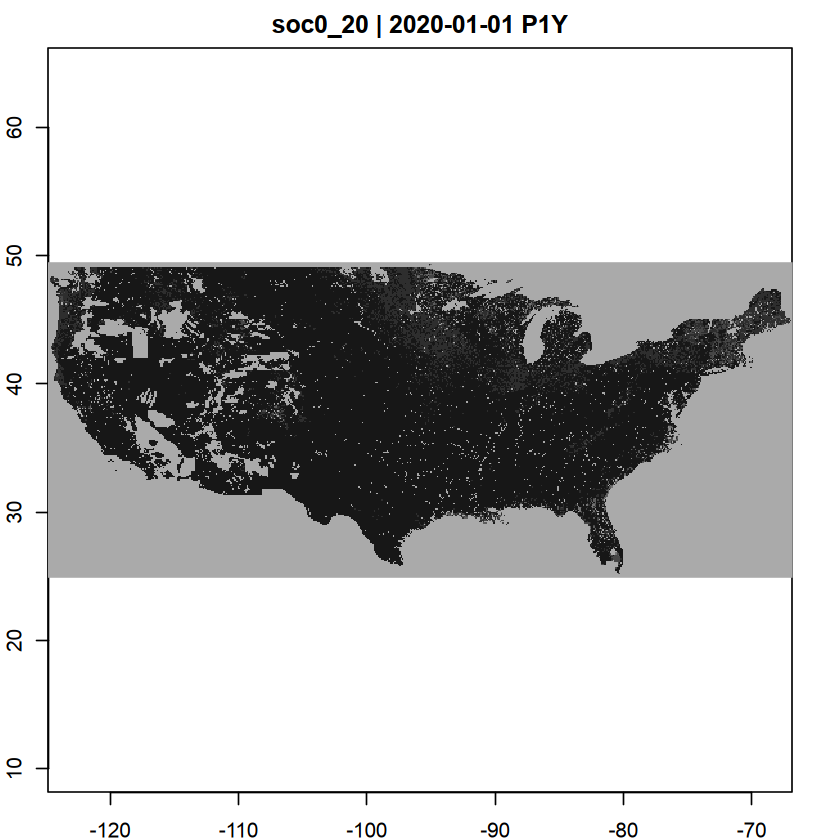

In [7]:
gdalcubes::gdalcubes_options(parallel = TRUE)
box <- c(xmin = -124.848974, ymin = 24.963083, xmax = -66.885444, ymax = 49.384358)

items <-  
  stac("https://planetarycomputer.microsoft.com/api/stac/v1")  |>
  stac_search(collections = "gnatsgo-rasters",
              bbox = box,
              limit = 1000)  |>
  post_request() |>
  items_sign(sign_planetary_computer())

# let's just do soil organic carbon in top 20cm
col <- stac_image_collection(items$features, asset_names = c("soc0_20"))

cube <- cube_view(srs ="EPSG:4326",
                  extent = list(t0 = "2020-01-01", t1 = "2020-12-31", # date is meaningless here
                                left = box[1], right = box[3],
                                top = box[4], bottom = box[2]),
                  dx = .1, dy = .1, dt = "P1Y")

data <-  raster_cube(col, cube)
data |> plot()

In [ ]:
gdalcubes::gdalcubes_options(parallel = TRUE)
geo_box <- c(
  xmin = -124.79, ymin = 24.41, xmax = -66.91, ymax = 49.38
)
prj_box <- c(
  xmin = -2916309.52, ymin = 153627.53, xmax = 2945750.47, ymax = 3255273.0
)

items <-
  stac("https://planetarycomputer.microsoft.com/api/stac/v1")  |>
  stac_search(
    collections = "gnatsgo-rasters",
    bbox = geo_box,
    limit = 1000
  )  |>
  post_request() |>
  items_sign(sign_planetary_computer())

# let's just do soil organic carbon in top 20cm
col <- stac_image_collection(items$features, asset_names = c("soc0_20"))

cube <- cube_view(
  srs ="EPSG:5701",
  extent = list(
    t0 = "2020-01-01", t1 = "2020-12-31", # date is meaningless here
    left = prj_box[1], bottom = prj_box[2], right = prj_box[3], top = prj_box[4]
  ),
  dx = 1000, dy = 1000, dt = "P1Y"
)

data <-  raster_cube(col, cube)
data |> plot()

In [ ]:
gdalcubes::gdalcubes_options(parallel = TRUE)
box <- c(xmin = -125, ymin = 24, xmax = -66, ymax = 50)

items <-
  stac("https://planetarycomputer.microsoft.com/api/stac/v1")  |>
  stac_search(
    collections = "gnatsgo-rasters",
    bbox = box,
    limit = 1000
  )  |>
  post_request() |>
  items_sign(sign_planetary_computer())

# let's just do soil organic carbon in top 20cm
col <- stac_image_collection(items$features, asset_names = c("soc0_20"))

# -2916309.52 153627.53
# 2945750.47 3255273.0
cube <- cube_view(
  srs ="EPSG:5701",
  extent = list(
    t0 = "2020-01-01", t1 = "2020-12-31", # date is meaningless here
    left = -2916309.52, right = 2945750.47, top = 3255273.0, bottom = 153627.53
  ),
  dx = 1000, dy = 1000, dt = "P1Y"
)

data <-  raster_cube(col, cube)
data |> plot()